# Capstone Project - The Battle of Neighbourhoods

## The Restaurant Capital of Toronto

## Table of contents
* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Analysis](#Analysis)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)

## Introduction

With great excitement I would like to share that I have been assigned an arduous task by the mayor of Toronto himself, John Tory.  He has asked me to name a neighbourhood as the Restaurant Capital of Toronto.  He will be using my results to create a marketing plan and social media campaign for the city, specifically focusing on attracting foodies and potential restaurateurs.

John Tory included some very specific criteria with this assignment.  He would like a Restaurant Capital to be awarded for the neighbourhood with the highest variety of restaurants.  Additionally, he would like me to create and name five distinct neighbourhood groups, with each group sharing common restaurant varieties.

To accomplish this task I will need to use the location data for each Toronto neighbourhood to pull venue details from Foursquare.

## Data

Data
For this project, I will be leveraging the location data used in my Segmenting and Clustering Neighbourhoods in Toronto assignment.  In that assignment, I scraped postal code, borough and neighbourhood information from a Wikipedia table.  I then merged that data with a CSV file containing coordinates for each Toronto postal code and then used those coordinates to pull data from Foursquare.

This time I will be pulling data from Foursquare only where the venue category is food.  I will use this data to calculate the neighbourhood with the highest number of restaurant types to award the Restaurant Capital title .  I will then use machine learning to group neighbourhoods by the types of restaurants that are common within them.

#### Neighbourhood Data

Let's start by importing the packages that we will be using

In [51]:
import requests
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
from geopy import distance
import seaborn as sns
print('all done')

Solving environment: done

# All requested packages already installed.

all done


Next we will extract the HTML table that contains are neighbourhood data from Wikipedia

In [2]:
wikipedia_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_page=requests.get(wikipedia_link)
page=raw_page.text
soup = BeautifulSoup(page,'lxml')
my_table=soup.find('table',{'class':'wikitable sortable'})

Then we create an empty dataframe to store this information within

In [3]:
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

Tornh = pd.DataFrame(columns=column_names)
Tornh

,PostalCode,Borough,Neighborhood


Then we use a function to scrape the neighbourhood data from the table and add it to our empty dataframe

In [4]:
for row in my_table.find_all('tr')[1:]:
    P_row=row.find_all('td')[0]
    B_row=row.find_all('td')[1]
    N_row=row.find_all('td')[2]
    N_row=N_row.text.split('\n')[0]
    
    if B_row.text in ['Not assigned']:
        pass
    
    elif N_row in 'Not assigned':
        Tornh = Tornh.append({'PostalCode': P_row.text,
                          'Borough': B_row.text,
                          'Neighborhood': B_row.text}, ignore_index=True)        
    else:
        Tornh = Tornh.append({'PostalCode': P_row.text,
                          'Borough': B_row.text,
                          'Neighborhood': N_row}, ignore_index=True)

Let's look at a preview of our data and note the number of columns and rows.. 3 columns and 103 rows.

In [5]:
gb = Tornh.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda x: x.str.cat(sep=', ')).to_frame().reset_index()
print(gb.shape)
gb.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Now we import a CSV file that contains the coordinates for each Toronto Postal Code and store the data in a new dataframe

In [6]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0


df_GC = pd.read_csv(body)
df_GC.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we can merge our two dataframes, joining on Postal code.  Again, we take a preview and note the number of rows and columns.. 103 rows, 5 columns.

In [7]:
df_full = pd.merge(gb, df_GC, left_on='PostalCode', right_on='Postal Code', how='left')
df_full=df_full.drop(['Postal Code'], axis=1)
print(df_full.shape)
df_full.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Folium

Before we use our location data to pull in venue details from Foursquare, let's plot our neighbourhoods on a map so that we can begin visualizing the city.

Let's start by pulling coordinates from Nominatim for Toronto, Ontario. Then we will use those coordinates to create a map of Toronto with folium. 

In [9]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explore")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Now we use a function to plot our map and add markers for each neighbourhood.

In [10]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_full['Latitude'], df_full['Longitude'], df_full['Borough'], df_full['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

When we pull in venue details from Foursquare, we will need to assign a search radius that will apply to all coordinates that we are searching around.  How far is each neighboughood from it's closest neighbour?

For this assignment, we will find a pair of adjacent neighbourhoods that seem to be the average distance apart and use geopy to calculate the distance between them.  This would be a great step to review in future iterations, perhaps even creating a function that calculates a radius for each neighbourhood.

I have selected Davisville North & Leaside.

In [11]:
df_full[df_full['Neighborhood'].str.contains('Leaside')]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
38,M4G,East York,Leaside,43.70906,-79.363452


In [13]:
df_full[df_full['Neighborhood'].str.contains('Davisville North')]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197


In [14]:
coords_1 = (43.70906, -79.363452)
coords_2 = (43.712751, -79.390197)

print(distance.distance(coords_1, coords_2).km)

2.1941673189485837


So the average distance between adjacent neighbourhoods is likely around 2 km.  Let's use a 1 km radius for our Foursquare search

#### Foursquare

We start by defining variables for my Foursquare credentials and Foursquare's category ID for food.  We will use these variables to create our request URL, and create a function to pull in venue details for each neighbourhood in our table.

In [15]:
CLIENT_ID = 'helo' # your Foursquare ID
CLIENT_SECRET = 'helo' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
food_cat = '4d4b7105d754a06374d81259'

In [16]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            food_cat,
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue ID',          
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
tor_venues = getNearbyVenues(names=df_full['Neighborhood'],
                                   latitudes=df_full['Latitude'],
                                   longitudes=df_full['Longitude']
                                  )

In [23]:
print(tor_venues.shape)
tor_venues.head()

(3777, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,4b914562f964a520d4ae33e3,Caribbean Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.802008,-79.198080,579a91b3498e9bd833afa78a,Fast Food Restaurant
2,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,4bb6b9446edc76b0d771311c,Fast Food Restaurant
3,"Rouge, Malvern",43.806686,-79.194353,Harvey's,43.800106,-79.198258,4b6718c2f964a5203f3a2be3,Fast Food Restaurant
4,"Rouge, Malvern",43.806686,-79.194353,Mr Jerk,43.801262,-79.199758,4ceaa2f0f8653704f906bec4,African Restaurant


## Methodology

Now that we have used our location data to generate a dataframe showing recommended restaurants in a 1 km radius, we will use the data to complete two analyses.
Firstly, we will look for unique restaurant categories within each neighbourhood.  The neighbourhood with the most unique restaurant categories will be crowned the Restaurant Capital of Toronto.  It is important to note that Foursquare only allows us to retrieve 100 venues per neighbourhood. We will be assuming that the top 100 recommended restaurants are representative of all restaurants in each neighbourhood.

Secondly, we will use machine learning to group neighbourhoods together by the types of restaurants that are common within them.  We will use the Kmeans algorithm to cluster the neighbourhoods into five groups, since that is the number that John Tory has requested.

Lastly, we will plot the clustered neighbourhoods on a map of Toronto, color-coded by cluster.  We will also review the most common restaurants in each cluster, and use this information to assign each group a name.


## Analysis

Now that we have all of our data compiled in a single dataframe, let's start by finding the neighbourhood with the greatest diversity of restaurant.  This will be the neighbourhood that we crown the Restaurant Capital of Toronto.

In [18]:
tor_gb=tor_venues.groupby(['Neighborhood']).nunique()
tor_gb=tor_gb.sort_values(by=['Venue Category'], ascending=False)
tor_gb.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
Neighborhood,,,,,,,,
"Harbord, University of Toronto",1,1,1,98,100,100,100,43
Church and Wellesley,1,1,1,98,100,100,100,42
"Little Portugal, Trinity",1,1,1,100,100,100,100,42
"Adelaide, King, Richmond",1,1,1,97,100,100,100,41
St. James Town,1,1,1,99,100,100,100,41


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


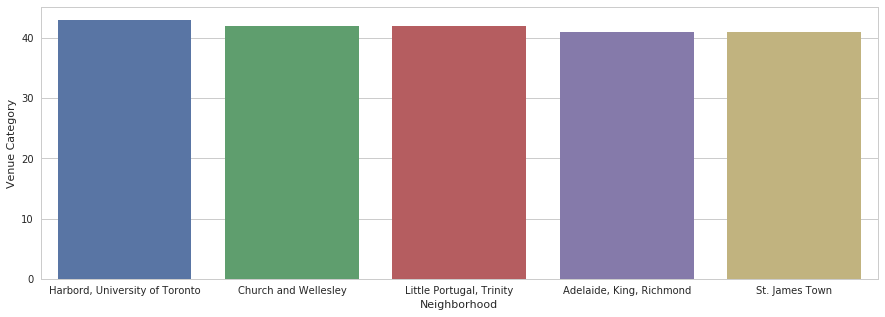

In [19]:
graph=tor_gb.head(5)#.reset_index()
#graph=graph.rename(index={'Neighborhood':'index'})
#graph.index
#raph=graph.reset_index()
sns.set(style="whitegrid", rc={'figure.figsize':(15,5)})
ax = sns.barplot(x=graph.index, y="Venue Category", data=graph)

It looks like the Harbord, Univeristy of Toronto neighbourhood is the Restaurant Capital of Toronto, with 43 unique types of restaurants.

Next we will use one-hot encoding to convert our categorical restaurant categories into numerical values.

In [21]:
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

tor_onehot['Neighborhoods'] = tor_venues['Neighborhood'] 

fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Neighborhoods,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Rouge, Malvern",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can then calculate the mean value for each restaurant category in each neighbourhood

In [22]:
tor_grouped = tor_onehot.groupby('Neighborhoods').mean().reset_index()
tor_grouped.head()

,Neighborhoods,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",0.0,0.0,0.040000,0.0,0.0,0.020000,0.000000,0.0,0.030000,...,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.020000,0.000000,0.0
1,Agincourt,0.0,0.0,0.025641,0.0,0.0,0.051282,0.025641,0.0,0.051282,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.025641,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.000000,0.0,0.0,0.000000,0.083333,0.0,0.083333,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.041667,0.000000,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


We can now use our mean values to calculate the top 5 most common types of restaurant in each neighbourhood.  We will store this information in a new dataframe.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

tor_venues_sorted = pd.DataFrame(columns=columns)
tor_venues_sorted['Neighborhoods'] = tor_grouped['Neighborhoods']

for ind in np.arange(tor_grouped.shape[0]):
    tor_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

tor_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Café,Restaurant,Japanese Restaurant,Italian Restaurant,Pizza Place
1,Agincourt,Chinese Restaurant,Caribbean Restaurant,Restaurant,Sandwich Place,Asian Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Korean Restaurant,Noodle House,Bakery,BBQ Joint
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Sandwich Place,Fried Chicken Joint,Sushi Restaurant,Japanese Restaurant
4,"Alderwood, Long Branch",Pizza Place,Donut Shop,Sandwich Place,Moroccan Restaurant,Wings Joint


Taking our one-hot encoded dataframe, we can now run our machine learning Kmeans algorithm to separate our neighbourhoods into 5 clusters.  We will add the cluster labels to our sorted dataframe and then merge it with our original dataframe with location data

In [25]:
tor_grouped_clustering = tor_grouped.drop('Neighborhoods', 1)

kmeans = KMeans(n_clusters=5, random_state=0).fit(tor_grouped_clustering)

kmeans.labels_[0:10]

array([2, 1, 1, 4, 4, 2, 0, 2, 2, 2], dtype=int32)

In [26]:
tor_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [27]:
tor_merged = df_full

tor_merged = tor_merged.join(tor_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')

print(tor_merged.shape)
tor_merged.head()

(103, 11)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Caribbean Restaurant,Greek Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,2.0,Breakfast Spot,Burger Joint,Italian Restaurant,Wings Joint,Doner Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4.0,Pizza Place,Fast Food Restaurant,Greek Restaurant,Burger Joint,Mexican Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,American Restaurant,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Wings Joint
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Bakery,Indian Restaurant,Chinese Restaurant,Wings Joint,Fast Food Restaurant


Now let's drop any rows with no venue information and change our cluster labels to intergers.

In [28]:
tor_merged.dropna(axis=0, inplace=True)
tor_merged.shape

(102, 11)

In [29]:
tor_merged['Cluster Labels']=tor_merged['Cluster Labels'].astype(int)
tor_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Caribbean Restaurant,Greek Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,2,Breakfast Spot,Burger Joint,Italian Restaurant,Wings Joint,Doner Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Pizza Place,Fast Food Restaurant,Greek Restaurant,Burger Joint,Mexican Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,American Restaurant,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Wings Joint
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Bakery,Indian Restaurant,Chinese Restaurant,Wings Joint,Fast Food Restaurant


Let's plot our neigherhoods on a map of Toronto again, but this time we will color code each neighbourhood by cluster.

In [50]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Lastly we must name each cluster, so let's take a look at the top restaurant types in each one.

Cluster 0 seems to have a lot of Asian restaurants so we will call it Asian Appetizers.

In [32]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Scarborough Village,0,Restaurant,Sandwich Place,Japanese Restaurant,Pizza Place,Fast Food Restaurant
19,Bayview Village,0,Japanese Restaurant,Chinese Restaurant,Café,Fast Food Restaurant,Wings Joint
23,York Mills West,0,Restaurant,Chinese Restaurant,French Restaurant,Pizza Place,Wings Joint
29,"Northwood Park, York University",0,Pizza Place,Restaurant,Sushi Restaurant,Sandwich Place,Fast Food Restaurant
72,Glencairn,0,Pizza Place,Italian Restaurant,Fast Food Restaurant,Restaurant,Asian Restaurant


Cluster 1 seems to have a lot of Chinese restaurants so we will call it Choice Chinese.

In [33]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Rouge, Malvern",1,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Caribbean Restaurant,Greek Restaurant
3,Woburn,1,American Restaurant,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Wings Joint
4,Cedarbrae,1,Bakery,Indian Restaurant,Chinese Restaurant,Wings Joint,Fast Food Restaurant
6,"East Birchmount Park, Ionview, Kennedy Park",1,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Asian Restaurant,Sandwich Place
7,"Clairlea, Golden Mile, Oakridge",1,Bakery,Diner,Fast Food Restaurant,Restaurant,Sandwich Place
10,"Dorset Park, Scarborough Town Centre, Wexford ...",1,Asian Restaurant,Bakery,Burger Joint,Indian Restaurant,Fast Food Restaurant
12,Agincourt,1,Chinese Restaurant,Caribbean Restaurant,Restaurant,Sandwich Place,Asian Restaurant
13,"Clarks Corners, Sullivan, Tam O'Shanter",1,Pizza Place,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,Vietnamese Restaurant
14,"Agincourt North, L'Amoreaux East, Milliken, St...",1,Chinese Restaurant,Korean Restaurant,Noodle House,Bakery,BBQ Joint
15,L'Amoreaux West,1,Chinese Restaurant,Fast Food Restaurant,Bakery,American Restaurant,Pizza Place


Cluster 2 seems to have a massive variety of restaurants will call it All You Can Eat.

In [34]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,"Highland Creek, Rouge Hill, Port Union",2,Breakfast Spot,Burger Joint,Italian Restaurant,Wings Joint,Doner Restaurant
9,"Birch Cliff, Cliffside West",2,Diner,Restaurant,Asian Restaurant,Thai Restaurant,Café
11,"Maryvale, Wexford",2,Middle Eastern Restaurant,Pizza Place,Burger Joint,Bakery,Korean Restaurant
20,"Silver Hills, York Mills",2,Cafeteria,Deli / Bodega,Wings Joint,Fish & Chips Shop,Diner
21,"Newtonbrook, Willowdale",2,Korean Restaurant,Café,Pizza Place,Middle Eastern Restaurant,Hot Dog Joint
22,Willowdale South,2,Pizza Place,Japanese Restaurant,Korean Restaurant,Ramen Restaurant,Fast Food Restaurant
26,Don Mills North,2,Pizza Place,Japanese Restaurant,Restaurant,Burger Joint,Mexican Restaurant
27,"Flemingdon Park, Don Mills South",2,Restaurant,Japanese Restaurant,Deli / Bodega,American Restaurant,Asian Restaurant
28,"Bathurst Manor, Downsview North, Wilson Heights",2,Pizza Place,Deli / Bodega,Mediterranean Restaurant,Diner,Fried Chicken Joint
30,"CFB Toronto, Downsview East",2,Turkish Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Middle Eastern Restaurant


Cluster 3 seems to have a lot of Cafés so we will call it the neighbourhood Café Central.

In [35]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
34,Victoria Village,3,Café,Portuguese Restaurant,French Restaurant,Pizza Place,Greek Restaurant
44,Lawrence Park,3,Café,Restaurant,Sushi Restaurant,Fast Food Restaurant,Wings Joint
68,"CN Tower, Bathurst Quay, Island airport, Harbo...",3,Café,Japanese Restaurant,Sushi Restaurant,Wings Joint,Fish & Chips Shop
102,Northwest,3,Café,Wings Joint,Fish & Chips Shop,Diner,Doner Restaurant


Cluster 4 seems to have a lot of pizza restaurants so we will call it Pizza Paradise.

In [36]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[2] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,"Guildwood, Morningside, West Hill",4,Pizza Place,Fast Food Restaurant,Greek Restaurant,Burger Joint,Mexican Restaurant
8,"Cliffcrest, Cliffside, Scarborough Village West",4,Pizza Place,Cajun / Creole Restaurant,Burger Joint,Wings Joint,Diner
81,"The Junction North, Runnymede",4,Pizza Place,Fast Food Restaurant,Sandwich Place,Vietnamese Restaurant,Burger Joint
89,"Alderwood, Long Branch",4,Pizza Place,Donut Shop,Sandwich Place,Moroccan Restaurant,Wings Joint
94,"Cloverdale, Islington, Martin Grove, Princess ...",4,Pizza Place,Fish & Chips Shop,American Restaurant,Café,Mexican Restaurant
95,"Bloordale Gardens, Eringate, Markland Wood, Ol...",4,Fish & Chips Shop,Sandwich Place,Café,Breakfast Spot,Pizza Place
96,Humber Summit,4,Pizza Place,Italian Restaurant,Bakery,Empanada Restaurant,Fish & Chips Shop
98,Weston,4,Pizza Place,Diner,Sandwich Place,Fried Chicken Joint,Café
99,Westmount,4,Pizza Place,Chinese Restaurant,Sandwich Place,Middle Eastern Restaurant,Breakfast Spot
101,"Albion Gardens, Beaumond Heights, Humbergate, ...",4,Pizza Place,Sandwich Place,Fried Chicken Joint,Sushi Restaurant,Japanese Restaurant


## Results

My analysis shows that the Toronto neighbourhood with the most unique restaurant categories is the Harbord, University of Toronto neighbourhood.  This neighbourhood will be declared the restaurant capital of Toronto, and highlighted in John Tory’s makerting/social media campaign.

The machne learning analysis of Toronto neighbourhoods generated five clusters of neighbourhoods that were named based on the most common restaurants in each cluster.  Cluster 0 has a wide variety of Asian restaurants, so it was named Asian Appetizers.  Cluster 1 had a large number of Chinese restaurants so it was named Choice Chinese.  Cluster 2 had a very wide variety of restaurant categories with each seemingly as prevalent as the next.  This cluster was named All You Can Eat.  Cluster 3 had a lot of cafés so it was called Café Central.  Lastly, cluster 4 was quite saturated with pizza restaurants so it was named Pizza Paradise.


## Discussion

Although the Harbord, Univesity neighbourhood was crowned the Restaurant Capital of Toronto, it won by a very slim margin.  There were quite a few neighbourhoods with only a few less unique categories of restaurants, which indicates that many areas of Toronto have diverse food options.  This measurement was also limited by Foursquares explore limit, which only allows you to pull in a maximum of 100 venues per neighbourhood.  Having access to include all restaurants in all neighbourhoods may have yielded a different result.

Five groups of neighbourhoods were successfully clustered based on the types of restaurants that are common within them.  However, this clustering may be improved in future iterations.  Some influential items that could be reviewed are the number of clusters, the radius searched for each neighbourhood, and the limit on the number of restaurants retrieved for each neighbouhood.  With the available credentials, the maximum number for this limit was used, but increasing or decreasing it would likely yiled different results.

Cluster 2 may also be a good item for review in future iterations.  It was the largest cluster by far and did not seem to have a unique trend in terms of what restaurants were common within it.  It may be enlightening to perform further machine learning algorithms on this cluster alone.

Since the cluster data from our analysis will be used to drive a marketing campaign geared towards foodies and restaurateurs, the city can advertise each neighbourhood for specific types of restaurants.  This data could be used to recommend neighbourhoods to foodies looking for particular types of dining.  It could also be used to recommend neighbourhoods to restauranteurs looking to open a specific type of restaurant.

## Conclusion

The purpose of this project was to name the neighbourhood with the highest variety of restaurants as the Restaurant Capital of Toronto, and to create and name five distinct neighbourhood groups, with each group sharing common restaurant varieties.  The Harbord, Univesity neighbourhood was crowned Restaurant Capital of Toronto.  The neighbourhoods of Toronto were clustered into five distinct groups: Asian Appetizers, Choice Chinese, All You Can Eat, Café Central and Pizza Paradise.  With this data, John Tory and his team can create a marketing campaign highlighting the diverse restaurants options available in Toronto, and where specific types of restaurants are located.